In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
# Read File
ab_testing = pd.read_csv('/Users/xiejing/Desktop/Codeoptest/Group Project/ab_testing.csv')

In [4]:
ab_testing.columns

Index(['User ID', 'Group', 'Page Views', 'Time Spent', 'Conversion', 'Device',
       'Location'],
      dtype='object')

In [5]:
ab_testing.shape

(5000, 7)

## 1. Introduction

### 1.1 Conversion Rate

In [6]:
# Step 1: Count total users per group
total_users = ab_testing.groupby('Group').size()

# Step 2: Count converted users (Conversion == 'Yes') per group
converted_users = ab_testing[ab_testing['Conversion'] == 'Yes'].groupby('Group').size()

# Step 3: Calculate conversion rate per group
conversion_rate_manual = (converted_users / total_users) * 100

print(conversion_rate_manual)


Group
A     5.398968
B    14.066909
dtype: float64


In [7]:
ab_testing['Group'].value_counts()


Group
A    2519
B    2481
Name: count, dtype: int64

In [8]:
ab_testing[ab_testing['Conversion'] == 'Yes']['Group'].value_counts()


Group
B    349
A    136
Name: count, dtype: int64

In [9]:
# One-liner: Calculate and show conversion rate (%) per group
conversion_rate_clean = (ab_testing.query("Conversion == 'Yes'").groupby('Group').size() / ab_testing.groupby('Group').size()) * 100

print(conversion_rate_clean)


Group
A     5.398968
B    14.066909
dtype: float64


/var/folders/bg/bg6_lhk10cb2v0n9434vjxb80000gn/T/ipykernel_43925/4250368526.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=conversion_rate_plot_data, x='Group', y='Conversion Rate (%)', palette='Set2')


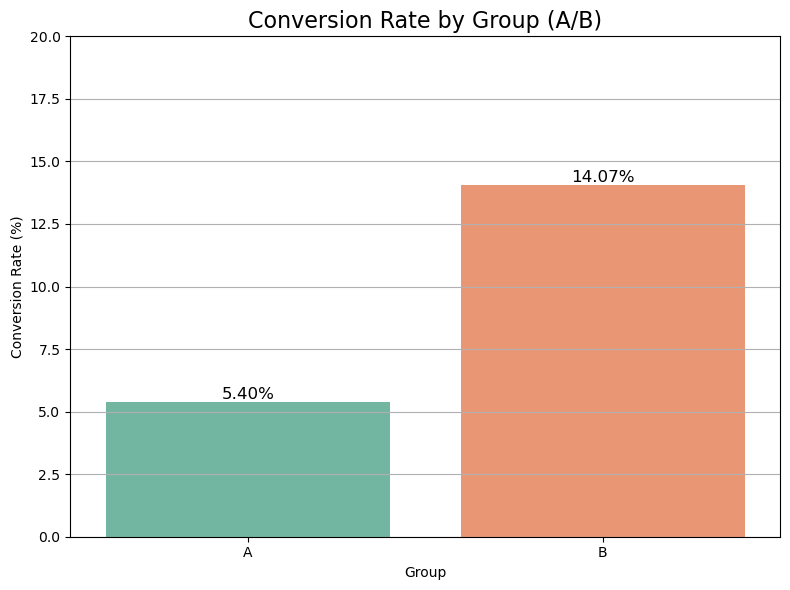

In [10]:

# Prepare data for plotting
conversion_rate_plot_data = conversion_rate_clean.reset_index()
conversion_rate_plot_data.columns = ['Group', 'Conversion Rate (%)']

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=conversion_rate_plot_data, x='Group', y='Conversion Rate (%)', palette='Set2')

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.title('Conversion Rate by Group (A/B)', fontsize=16)
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Group')
plt.ylim(0, 20)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 1.2 Device Conversion

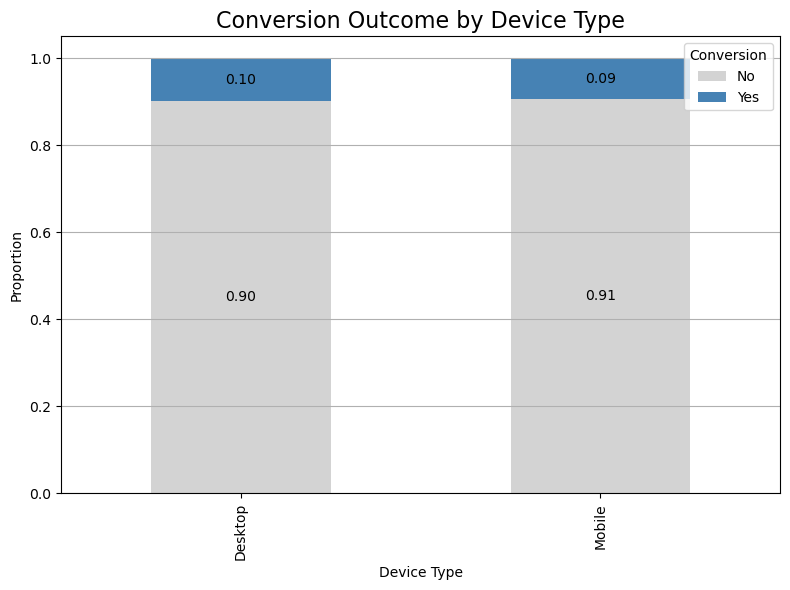

In [11]:

# Calculate device conversion
device_conversion = (
    ab_testing.groupby(['Device', 'Conversion'])
    .size()
    .unstack(fill_value=0)
)

# Normalize by device to get percentage
device_conversion_norm = device_conversion.div(device_conversion.sum(axis=1), axis=0)

# Plot with labels
fig, ax = plt.subplots(figsize=(8, 6))
device_conversion_norm.plot(kind='bar', stacked=True, ax=ax, color=['lightgray', 'steelblue'])

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=10, color='black')

plt.title('Conversion Outcome by Device Type', fontsize=16)
plt.ylabel('Proportion')
plt.xlabel('Device Type')
plt.legend(title='Conversion', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Almost no difference is found in terms of conversion outcome by device types.

## 2. Core Data Analysis + Visualization

- Scatter Plot: Page Views vs Time Spent (colored by Conversion)
- Box Plot: Time Spent vs Conversion Outcome
- Grouped Bar Chart: Location vs Conversion Rate

### 2.1 Cleaning Data

In [12]:
# Corrected numerical columns
numerical_cols = ['Page Views', 'Time Spent']

outlier_summary = {}

# Analyze for outliers and missing values
for col in numerical_cols:
    summary = {
        'min': ab_testing[col].min(),
        '1st_quartile': ab_testing[col].quantile(0.25),
        'median': ab_testing[col].median(),
        '3rd_quartile': ab_testing[col].quantile(0.75),
        'max': ab_testing[col].max(),
        'IQR': ab_testing[col].quantile(0.75) - ab_testing[col].quantile(0.25),
        'missing_values': ab_testing[col].isnull().sum()
    }
    outlier_summary[col] = summary

outlier_summary


{'Page Views': {'min': 1,
  '1st_quartile': 4.0,
  'median': 8.0,
  '3rd_quartile': 11.0,
  'max': 14,
  'IQR': 7.0,
  'missing_values': 0},
 'Time Spent': {'min': 40,
  '1st_quartile': 137.0,
  'median': 243.0,
  '3rd_quartile': 346.0,
  'max': 449,
  'IQR': 209.0,
  'missing_values': 0}}

No evident outliers were found, the data was pretty clean.

###  2.2 scatter plot of Page Views vs Time Spent colored by Conversion

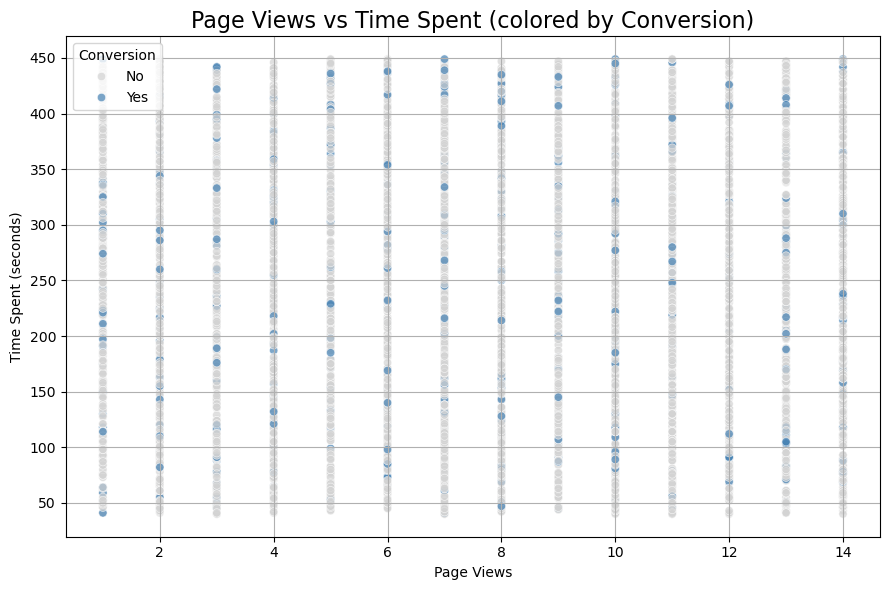

In [13]:

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=ab_testing,
    x='Page Views',
    y='Time Spent',
    hue='Conversion',
    palette={'Yes': 'steelblue', 'No': 'lightgray'},
    alpha=0.7
)

plt.title('Page Views vs Time Spent (colored by Conversion)', fontsize=16)
plt.xlabel('Page Views')
plt.ylabel('Time Spent (seconds)')
plt.grid(True)
plt.legend(title='Conversion')
plt.tight_layout()
plt.show()


The graph is not ideal, tableau gives better results

### 2.3 Create the box plot for Time Spent vs Conversion Outcome 

/var/folders/bg/bg6_lhk10cb2v0n9434vjxb80000gn/T/ipykernel_43925/2840319339.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Conversion', y='Time Spent', data=ab_testing, palette='Set2')


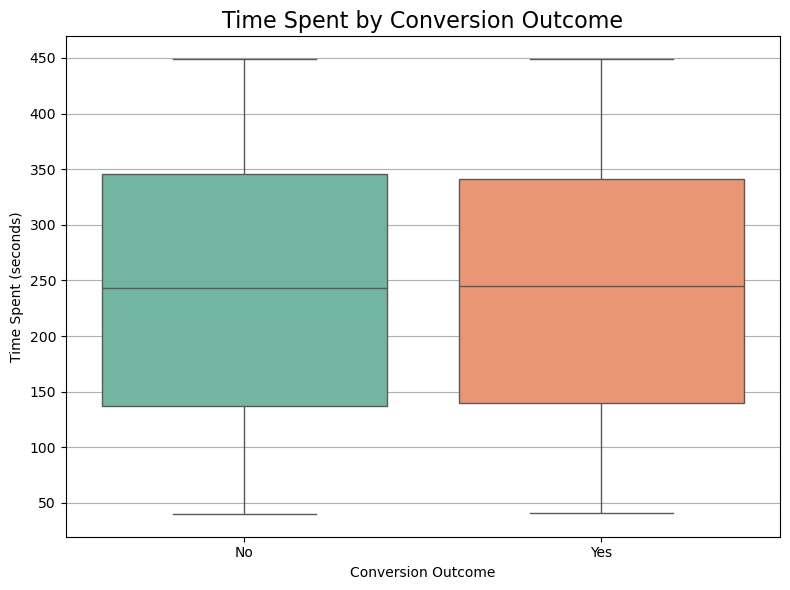

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Conversion', y='Time Spent', data=ab_testing, palette='Set2')

plt.title('Time Spent by Conversion Outcome', fontsize=16)
plt.xlabel('Conversion Outcome')
plt.ylabel('Time Spent (seconds)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### 2.4 Calculate conversion rates by location

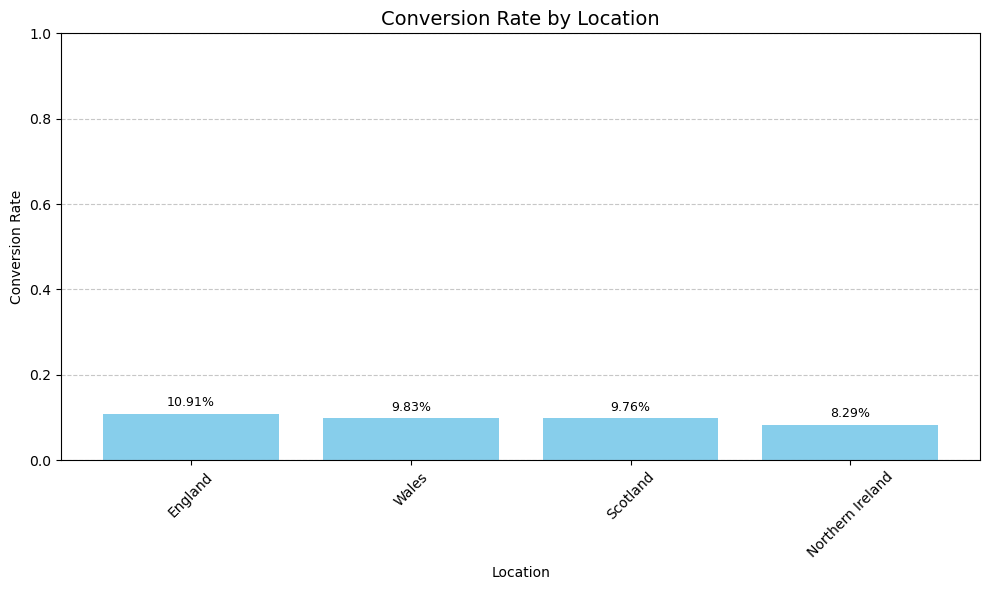

In [15]:

location_conversion = (
    ab_testing.groupby(['Location', 'Conversion'])
    .size()
    .unstack(fill_value=0)
)

# Compute conversion rate
location_conversion['Conversion Rate'] = location_conversion['Yes'] / (location_conversion['Yes'] + location_conversion['No'])

# Sort by conversion rate
location_conversion_sorted = location_conversion.sort_values(by='Conversion Rate', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(location_conversion_sorted.index, location_conversion_sorted['Conversion Rate'], color='skyblue')

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', va='bottom', fontsize=9)

plt.title('Conversion Rate by Location', fontsize=14)
plt.ylabel('Conversion Rate')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 3. Statistical Test & Insights Exploration

### 3.1  Chi-Square Test for Conversion Rate difference between Group A and Group B

To help determine whether the observed difference in conversion rates is statistically significant — or just due to random chance.

In [16]:
from scipy.stats import chi2_contingency

# Create the contingency table: Group vs Conversion outcome
conversion_table = pd.crosstab(ab_testing['Group'], ab_testing['Conversion'])

# Run the Chi-Square test
chi2, p, dof, expected = chi2_contingency(conversion_table)

# Output results
chi2_result = {
    "Chi-Square Statistic": chi2,
    "p-value": p,
    "Degrees of Freedom": dof,
    "Expected Frequencies": expected
}
conversion_table, chi2_result


(Conversion    No  Yes
 Group                
 A           2383  136
 B           2132  349,
 {'Chi-Square Statistic': 106.22812337440538,
  'p-value': 6.571736018334225e-25,
  'Degrees of Freedom': 1,
  'Expected Frequencies': array([[2274.657,  244.343],
         [2240.343,  240.657]])})

#### Interpretation
The p-value is extremely small, which means the difference in conversion rates between Group A and Group B is statistically significant.

This suggests that whatever change was made in Group B had a real impact on conversion behavior — it’s not due to random chance.


### 3.2 Visualize the Results

Each group (A and B) shows two bars:
Blue  = actual (observed) data
Grey  = what we’d expect if there were no difference between A and B
The bigger the gap between observed and expected, the more statistically significant the result is.

This chart compares actual conversion outcomes with statistically expected values.
Group B shows significantly more conversions than expected, confirming that the version change had a real, positive impact.”

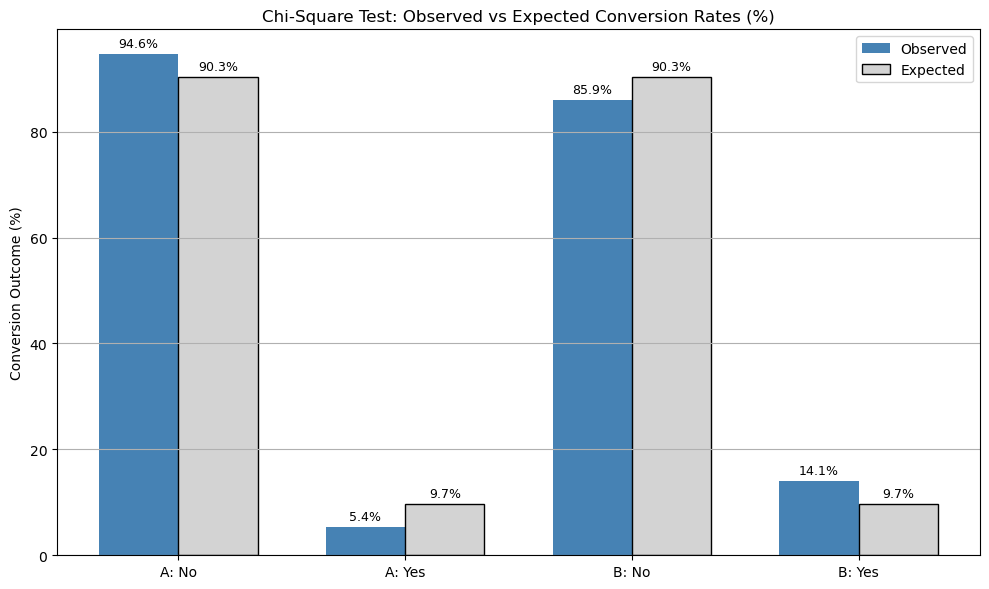

In [26]:

from scipy.stats import chi2_contingency

# Step 1: Create contingency table
conversion_table = pd.crosstab(ab_testing['Group'], ab_testing['Conversion'])

# Step 2: Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(conversion_table)

# Step 3: Calculate observed and expected percentages
observed = conversion_table.values
expected = expected

observed_pct = (observed.T / observed.sum(axis=1)).T * 100
expected_pct = (expected.T / expected.sum(axis=1)).T * 100

# Step 4: Prepare plot
labels = ['A: No', 'A: Yes', 'B: No', 'B: Yes']

# Flatten observed and expected percentages in the right order
observed_pct_flat = [observed_pct[0][0], observed_pct[0][1], observed_pct[1][0], observed_pct[1][1]]
expected_pct_flat = [expected_pct[0][0], expected_pct[0][1], expected_pct[1][0], expected_pct[1][1]]

x = np.arange(len(labels))  # 4 positions
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot side-by-side bars for each outcome
bars_obs = ax.bar(x - bar_width/2, observed_pct_flat, width=bar_width, label='Observed', color='steelblue')
bars_exp = ax.bar(x + bar_width/2, expected_pct_flat, width=bar_width, label='Expected', color='lightgray', edgecolor='black')

# Add percentage labels
for bars in [bars_obs, bars_exp]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Final formatting
ax.set_ylabel('Conversion Outcome (%)')
ax.set_title('Chi-Square Test: Observed vs Expected Conversion Rates (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 3.3 Z-Test

In [20]:

from statsmodels.stats.proportion import proportions_ztest

# Count conversions and totals for each group
conversion_counts = ab_testing[ab_testing['Conversion'] == 'Yes'].groupby('Group')['Conversion'].count()
total_counts = ab_testing.groupby('Group')['Conversion'].count()

# Prepare counts (ensure order is Group A, Group B)
successes = [conversion_counts.get('A', 0), conversion_counts.get('B', 0)]
totals = [total_counts.get('A', 0), total_counts.get('B', 0)]

# Run two-proportion z-test
z_stat, p_value = proportions_ztest(count=successes, nobs=totals)

z_stat, p_value


(-10.354488520266216, 3.9931511894201938e-25)

- The very large absolute z-statistic and extremely low p-value indicate a highly significant difference between the conversion rates of Group A and Group B, so, we can confidently say that the change in Group B (whatever change was tested) had a real impact on conversion rates.


### 3.4 Correlation analysis

In [23]:

from scipy.stats import pearsonr, spearmanr, pointbiserialr

# Encode 'Conversion' as numeric for correlation purposes (Yes = 1, No = 0)
ab_testing['Conversion Numeric'] = ab_testing['Conversion'].map({'No': 0, 'Yes': 1})

### 1️⃣ Page Views ↔ Time Spent
pearson_pv_ts, _ = pearsonr(ab_testing['Page Views'], ab_testing['Time Spent'])
spearman_pv_ts, _ = spearmanr(ab_testing['Page Views'], ab_testing['Time Spent'])

print(f"Page Views ↔ Time Spent:")
print(f"  Pearson correlation: {pearson_pv_ts:.3f}")
print(f"  Spearman correlation: {spearman_pv_ts:.3f}\n")

### 2️⃣ Page Views ↔ Conversion (Point-biserial correlation)
r_pb_pv, _ = pointbiserialr(ab_testing['Conversion Numeric'], ab_testing['Page Views'])
print(f"Page Views ↔ Conversion (Point-biserial): {r_pb_pv:.3f}")

### 3️⃣ Time Spent ↔ Conversion (Point-biserial correlation)
r_pb_ts, _ = pointbiserialr(ab_testing['Conversion Numeric'], ab_testing['Time Spent'])
print(f"Time Spent ↔ Conversion (Point-biserial): {r_pb_ts:.3f}")


Page Views ↔ Time Spent:
  Pearson correlation: -0.001
  Spearman correlation: -0.001

Page Views ↔ Conversion (Point-biserial): -0.018
Time Spent ↔ Conversion (Point-biserial): 0.002


Correlation analysis reveals that neither additional page views nor extended time spent on site are significantly associated with higher conversion likelihood. This may indicate that users who convert do so efficiently, while extended browsing and time may reflect friction or difficulty rather than deeper engagement. Streamlining user journeys may improve conversion outcomes.

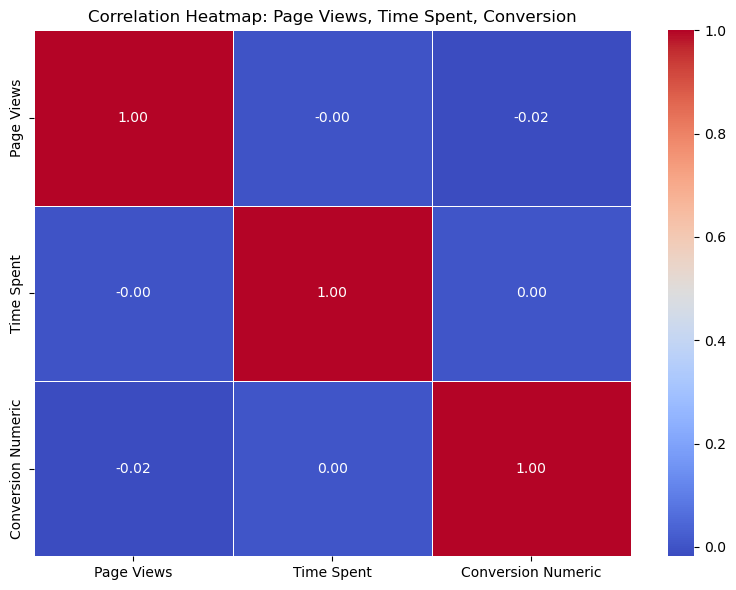

In [27]:
# Encode Conversion as numeric
ab_testing['Conversion Numeric'] = ab_testing['Conversion'].map({'No': 0, 'Yes': 1})

# Select numeric columns for correlation
corr_data = ab_testing[['Page Views', 'Time Spent', 'Conversion Numeric']]

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Page Views, Time Spent, Conversion')
plt.tight_layout()
plt.show()
